# The Unreally Notebook
### Step 1 - load data & helper functions


In [79]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [65]:
# path to dataset
DATAPATH = 'Data/big_chungus.xlsx' #'balanced3360.csv'

In [66]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s

# creates a vocabulary without stop words
def create_vocab(df):
    print("creating vocabulary...")
    vocab = []
    for i in range(len(df)-1):
            vocab.append(preprocess((df.iloc[i])['head']))
            vocab.append(preprocess((df.iloc[i])['body']))
    vocab_df = pd.DataFrame(vocab)
    
    counter = Counter(" ".join(vocab_df[0]).split()).most_common(5000)
    counter_df = pd.DataFrame(counter)
    
    # safe as file for use in API
    counter_df.to_csv('./kowalsky_vocab.csv')

    return counter_df


In [67]:
# creates & fits bow & tfidf vectorizer to dataset
# gets called in StanceDataset().__init__
def fit_vectorizers(dataset):
    print('fitting vectorizer...')

    # create array of all texts in dataset
    data = [(dataset.iloc[i])['head'] for i in range(len(dataset))] # headlines
    data += ((dataset.iloc[i])['body'] for i in range(len(dataset))) # bodies

    vocab = create_vocab(dataset)[0]
    
    # fit to dataset (creates dictionary)
    bow = CountVectorizer(
        vocabulary=vocab,
        max_features=5000,
    )
    tfidf = TfidfVectorizer(
        vocabulary=vocab,
        max_features=5000,
    )
    bow.fit(data)
    tfidf.fit(data)
    print('vectorizer ready!')
    return bow, tfidf

In [68]:
"""
Code block to test if the fit vectorizer sub-pipeline works. It calls:
fit_vectorizer()
    create_vocab()
        preprocess()
"""
# bow, tfidf = fit_vectorizers(df)
# test_input = ['super cool test input string']

# print(len(bow.vocabulary_))
# bow.transform(test_input).shape

'\nCode block to test if the fit vectorizer sub-pipeline works. It calls:\nfit_vectorizer()\n    create_vocab()\n        preprocess()\n'

### Step 2 - define pytorch custom dataset class

In [139]:
# config
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# custom dataset class
class StanceDataset(Dataset):
    def __init__(self, stance_df,  val_split=False):
        """  Initalizes vectorizers, defines train/test splits
        Args:
            stance_df (pandas.DataFrame): the dataset
        """
        self.df = stance_df
        
        self._bow, self._tfidf = fit_vectorizers(stance_df)
        
        # splits (train, test, validation) 80/20 
        self.train, self.test = train_test_split(self.df, test_size=0.2, shuffle=True)
        if val_split == True:   
            # 50/50 val/test
            self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
            self.val_len = len(self.val)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'test': (self.test, self.test_len)}
        if val_split == True:
            self._lookup_dict.update({'val': (self.val, self.val_len)})

        self.set_split('train')


    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        Args:
            index (int): index to current data point
        Returns:
            dictionary holding tensor data point feature (x_data) and skalar tensor label (y_data)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        
        # transform claim (headline/tweet) and target (body) to bowTF vector
        bow_x = self._bow.transform(claim)
        bow_y = self._bow.transform(body)

        # transform claim (headline/tweet) and target (body) to TFIDF vector
        tfidf_x = self._tfidf.transform(claim)
        tfidf_y = self._tfidf.transform(body)
        
        # take cosine similary of TFIDF vectors
        cosim = cosine_similarity(tfidf_x, tfidf_y)
        
        # concat x+cosim+y to input vector & convert to tensor
        claim_df = pd.DataFrame(bow_x.toarray()) 
        body_df = pd.DataFrame(bow_y.toarray())
        cosim_df = pd.DataFrame(cosim)
        
        x_data = (pd.concat([claim_df, cosim_df, body_df],axis=1)).to_numpy()
        x_data = torch.from_numpy(x_data)

        # get stance & convert to tensor
        y_data = row['Stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data])
        return {'x_data': x_data,
                'y_target': y_data}

In [100]:
def load_dataset(excel=True):
    """
    applies dataset class to dataset located at DATAPATH
    args:
        excel (bool): default true for .xlsx, else set false
    """
    print('loading dataset...')
    if excel == True:
        df = pd.read_excel(
            DATAPATH, 
            index_col=None, 
            header=0   
        )
    else:
        df = pd.read_csv(
            DATAPATH, 
            index_col=None,
            header=0   
        )
    print('loaded!')
    
    dataset = StanceDataset(df, val_split=False)
    return dataset

In [140]:
data = load_dataset(excel=False)

loading dataset...
loaded!
fitting vectorizer...
creating vocabulary...
vectorizer ready!


In [141]:
"""
Test block for getitem. This is what the training loop will call
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

d = data.__getitem__(1)
print(d['x_data'])
print(d['y_target'])

should be the lenght of train split:  2688
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
tensor(0)


### Weighted Sampler

{'agree': 840, 'disagree': 840, 'discuss': 840, 'unrelated': 840}
Text(0.5, 1.0, 'class distribution')


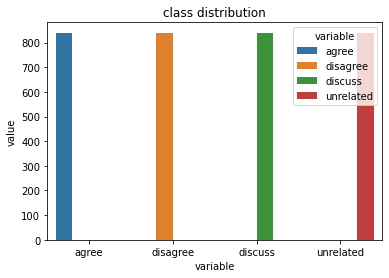

In [142]:
# distribution of labels (class distribution)
def dist_of(df):
    class_distribution = (pd.value_counts(df['Stance'])).to_dict()
    print(class_distribution)
    print(sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title('class distribution'))

dist_of(data.df)

In [143]:
def load_sampler(datasplit):
    # get list of class distribution
    class_count = list(pd.value_counts(datasplit['Stance']))
    print(f'class dist: {class_count}')

    class_weights = 1./torch.tensor(class_count, dtype=torch.float)

    stance_map = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2,
    "unrelated": 3
    }
    target_list = []
    for i in range(len(datasplit)):
        target_list.append(stance_map[(datasplit.iloc[i]['Stance'])])

    # list of weight for each sample
    class_weights_all = class_weights[target_list]

    # create sampler for split
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )
    print('weighted sampler loaded!')
    return weighted_sampler

In [144]:
train_sampler = load_sampler(data._target_df)

class dist: [689, 674, 665, 660]
weighted sampler loaded!


### Step 3 - Define model & training

In [109]:
# hyperparameters
in_dim = 10001
hidden_dim = 100
out_dim = 4
epochs = 45
batch = 32
lr = 0.001

In [125]:
# re-usable way to create dataloader
def make_batches(dataset, batch_size, shuffle=True, drop_last=True, sampler=None):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, sampler=sampler)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [126]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

criterion = nn.CrossEntropyLoss() # this also applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [87]:
"""
Test block to check if enumerate works correctly 
(data should return 2 values: input, label)
"""
# data.set_split('train')
# batch_loader = make_batches(data, batch)
# for i, sample in enumerate(batch_loader):
#     if i % 100 == 0:
#         print(i)
#     print(sample['x_data'])
#     print(sample['y_target'])

'\nTest block to check if enumerate works correctly \n(data should return 2 values: input, label)\n'

In [ ]:
"""
training loop
"""

loss_vals=  []
for epoch in range(epochs):

    # setup
    data.set_split('train')
    # shuffle off because sampler does it for us
    train_loader = make_batches(data, batch,shuffle=False, sampler=train_sampler)

    running_loss = 0.
    last_loss = 0.
    epoch_loss = []

    # enumerate to track the batch index and do some intra-epoch reporting
    for i, sample in enumerate(train_loader):
        # zero gradients each batch
        optimizer.zero_grad()
        
        inputs = ((sample)['x_data']).float()
        labels = sample['y_target']

        # predict for batch
        outputs = model(inputs)

        # compute loss and gradients
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.item())
        loss.backward()

        # adjust weights
        optimizer.step()

        # report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
        
    # append avg loss per epoch to loss vals
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

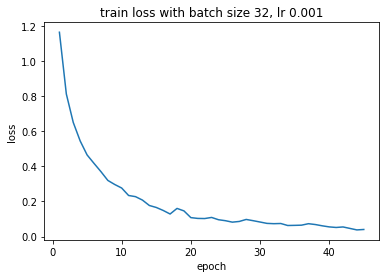

In [49]:
# plot loss once finished
def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    plt.title(f'train loss with batch size {batch}, lr {lr}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
# plot loss when finished
my_plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)

In [50]:
# set test split
data.set_split('test')
test_loader = make_batches(data, batch)

# accuracy
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    y_pred = []
    y_true = []
    for i, sample in enumerate(test_loader):
        
        if batch == 1:
            inputs = (sample['x_data'])[0].float()
        else:
            inputs = ((sample)['x_data']).float()
        labels = sample['y_target']
        
        
        # test the trained model
        outputs = model(inputs)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

        n_samples += labels.shape[0] # gives us n of samples of current batch
        n_correct += (predictions == labels).sum().item()

    
    # accuracy in percent
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')


accuracy = 69.19642857142857


In [59]:
# save the model
#torch.save(model.state_dict(), "./kowalsky_72_balanced.pth")

<AxesSubplot:title={'center':'cf matrix of testadata size 672'}>

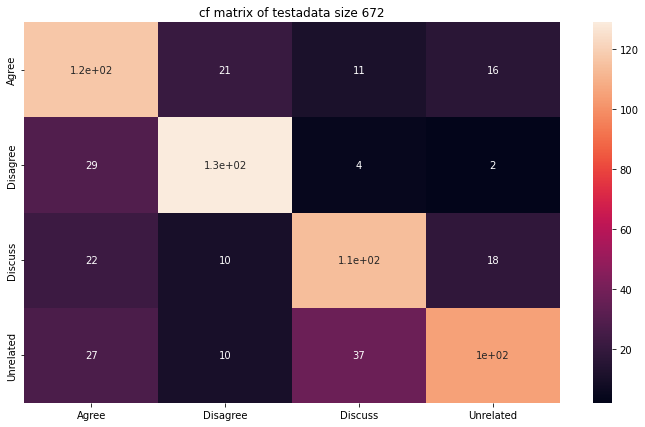

In [51]:
# confusion matrix

classes = ('Agree', 'Disagree', 'Discuss', 'Unrelated')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(f'cf matrix of testadata size {len(data._target_df)}')
sns.heatmap(df_cm, annot=True)

In [ ]:
# TODO f1 score